In [ ]:
yapılacaklar:
    
Datadan 0ları at
datetime convert to date-hour

In [ ]:
weather_[train/test].csv

site_id
air_temperature - Degrees Celsius
cloud_coverage - Portion of the sky covered in clouds, in oktas
dew_temperature - Degrees Celsius
precip_depth_1_hr - Millimeters
sea_level_pressure - Millibar/hectopascals
wind_direction - Compass direction (0-360)
wind_speed - Meters per second

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import holidays
from sklearn.metrics import mean_squared_error

In [2]:
train_data=pd.read_csv('train.csv')
building_metadata=pd.read_csv('building_metadata.csv')
#test_data=pd.read_csv('test.csv')
#sample_submission=pd.read_csv('sample_submission.csv')
#weather_train=pd.read_csv('weather_train.csv')
#weather_test=pd.read_csv('weather_test.csv')

In [3]:
def timestamp_parser(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H')
    return df

In [4]:
train_data=timestamp_parser(train_data)
#test_data=timestamp_parser(test_data)
#weather_train=timestamp_parser(weather_train)
#weather_test=timestamp_parser(weather_test)

In [5]:
train_all=train_data.merge(building_metadata, on='building_id', how='left')
#train_all=train_all.merge(weather_train, on=['site_id','timestamp'], how='left')
train_all=timestamp_parser(train_all)
train_all.set_index('timestamp',inplace=True)

In [6]:
train_all['meter_reading_log']=np.log1p(train_all['meter_reading'])


In [7]:
#Null Percentage
#null_percentage=(train_all.isnull().mean()*100).round(2)
#null_percentage

In [8]:
#Drop mostly null columns:
#train_all=train_all.drop(columns=['year_built','floor_count','cloud_coverage','precip_depth_1_hr'], axis=1)

In [9]:
#Filter Only Larger 0 Values
train_all=train_all[train_all.index.weekday<3]
filtered_train=train_all[train_all['meter_reading']>0]
train_6 = filtered_train[(filtered_train['site_id'] == 6) & (filtered_train['primary_use'] == 'Education')]

<Figure size 600x300 with 0 Axes>

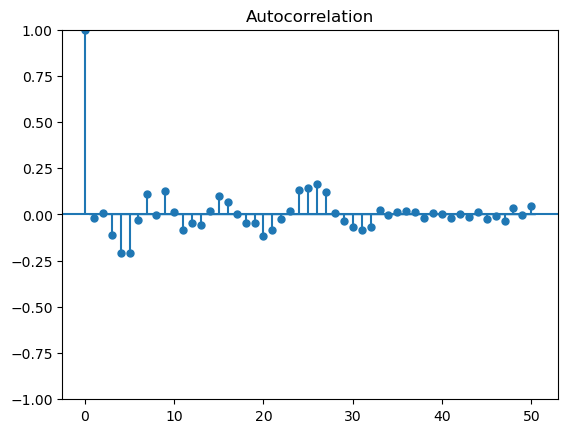

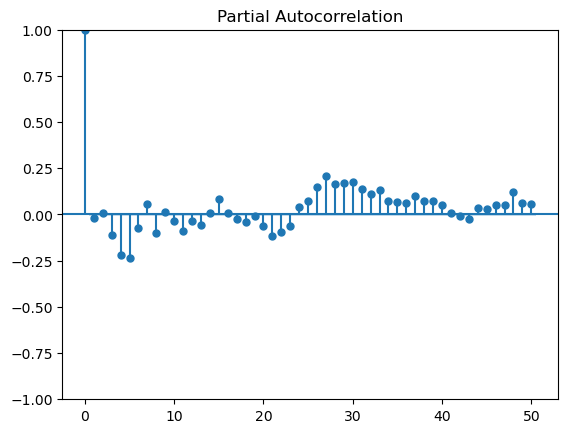

In [10]:
#ACF PACF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(6, 3))
acf_original=plot_acf(train_6['meter_reading'])
pacf_original=plot_pacf(train_6['meter_reading'])
plt.show()


In [21]:
#ADF Test
from statsmodels.tsa.stattools import adfuller
adf_test=adfuller(train_6['meter_reading_log'])
print(adf_test[1])

0.0


In [12]:
train_6.shape

(92457, 9)

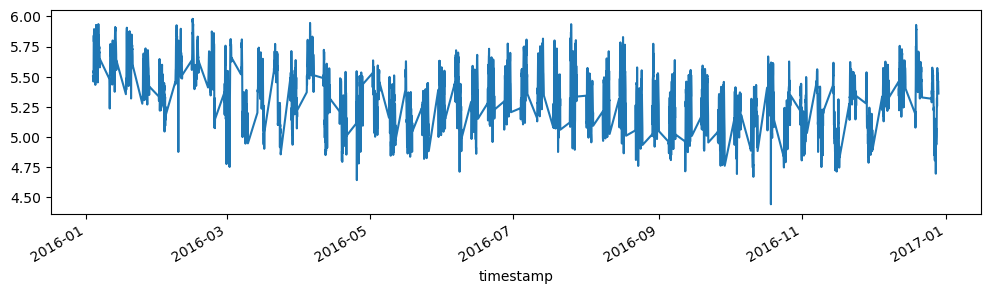

In [13]:
plt.figure(figsize=(12, 3))
electricity=train_6.groupby(["timestamp"])["meter_reading_log"].aggregate("mean")
electricity.plot()
plt.show()



<Figure size 1200x1000 with 0 Axes>

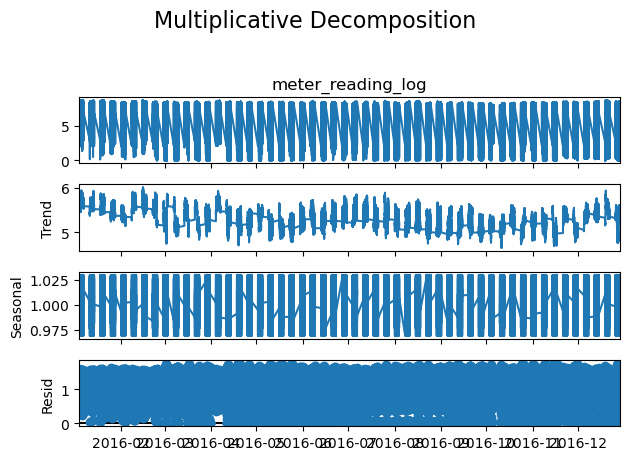

In [14]:
plt.figure(figsize=(12, 10))
multiplicative_decomposition = seasonal_decompose(train_6['meter_reading_log'], model='multiplicative', period=100)

# Additive Decomposition
additive_decomposition = seasonal_decompose(train_6['meter_reading_log'], model='additive', period=100)
# Plot
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

/Users/ozge/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/ozge/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/ozge/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/ozge/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


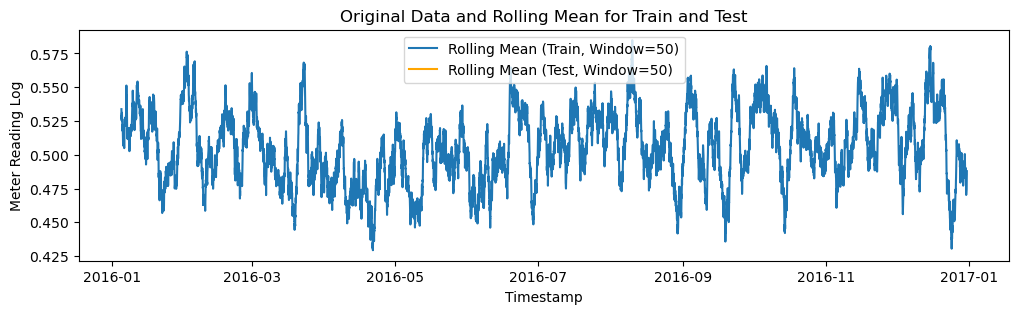

In [27]:
#ARIMA

rng = pd.date_range('2016-01-01', '2016-12-31', freq='H')
train_6 = pd.DataFrame({'timestamp': rng, 'meter_reading_log': np.random.rand(len(rng))})

# Set 'timestamp' as the index
train_6.set_index('timestamp', inplace=True)

# Split the data into training and testing sets
train_size = int(len(train_all) * 0.8)
train, test = train_6.iloc[:train_size], train_6.iloc[train_size:]

rolling_mean_train = train['meter_reading_log'].rolling(window=100).mean()
rolling_mean_test = test['meter_reading_log'].rolling(window=100).mean()


# Fit ARIMA model
order = (0, 1, 5)  # Adjust the order based on your data, as data stationary
arima_model = ARIMA(train['meter_reading_log'], order=order)
fitted_model = arima_model.fit()


plt.figure(figsize=(12, 3))
#plt.plot(train.index, train['meter_reading_log'], label='Train', color='blue')
plt.plot(rolling_mean_train.index, rolling_mean_train, label='Rolling Mean (Train, Window=50)')

#plt.plot(test.index, test['meter_reading_log'], label='Test', color='green')
plt.plot(rolling_mean_test.index, rolling_mean_test, label='Rolling Mean (Test, Window=50)', color='orange')
plt.title('Original Data and Rolling Mean for Train and Test')
plt.xlabel('Timestamp')
plt.ylabel('Meter Reading Log')
plt.legend()
plt.show()

In [28]:
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:      meter_reading_log   No. Observations:                 8761
Model:                 ARIMA(0, 1, 5)   Log Likelihood               -1567.059
Date:                Tue, 28 Nov 2023   AIC                           3146.117
Time:                        10:11:13   BIC                           3188.585
Sample:                    01-01-2016   HQIC                          3160.587
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0005      0.011    -94.576      0.000      -1.021      -0.980
ma.L2         -0.0063      0.015     -0.421      0.674      -0.035       0.023
ma.L3          0.0162      0.015      1.074      0.2

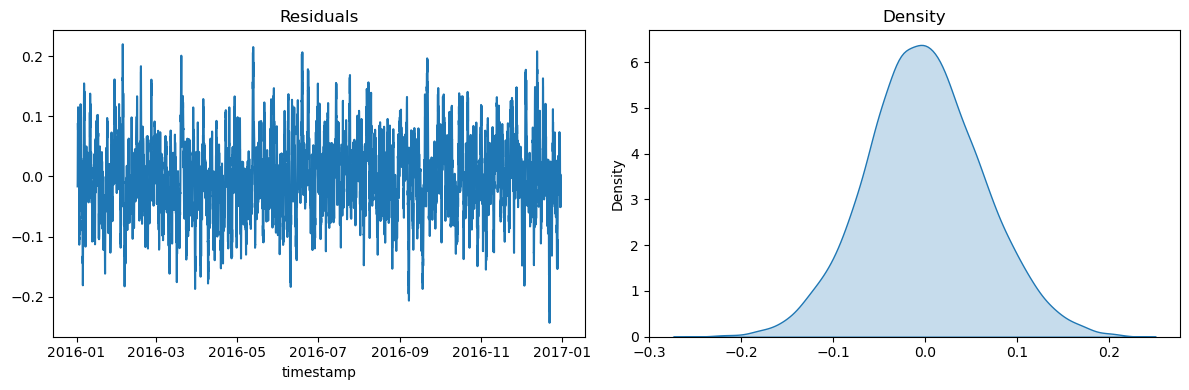

In [45]:
residuals = fitted_model.resid[1:].rolling(window=20).mean()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # Adjust the figsize as needed

# Plot residuals
sns.lineplot(x=residuals.index.get_level_values("timestamp"), y=residuals, ax=ax[0])
ax[0].set_title('Residuals')

# Plot density
sns.kdeplot(residuals.dropna(), ax=ax[1], fill=True)
ax[1].set_title('Density')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()



In [46]:
import pmdarima as pm
auto_arima=pm.auto_arima(train_6, stepwise=False, seasonal=False)
auto_arima

ModuleNotFoundError: No module named 'pmdarima'